In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
# Set to LateX
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amsfonts}\usepackage{amssymb}"
})

In [2]:
# Prepare to read multiple result files
testname = 'EPSvsNt1'
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))

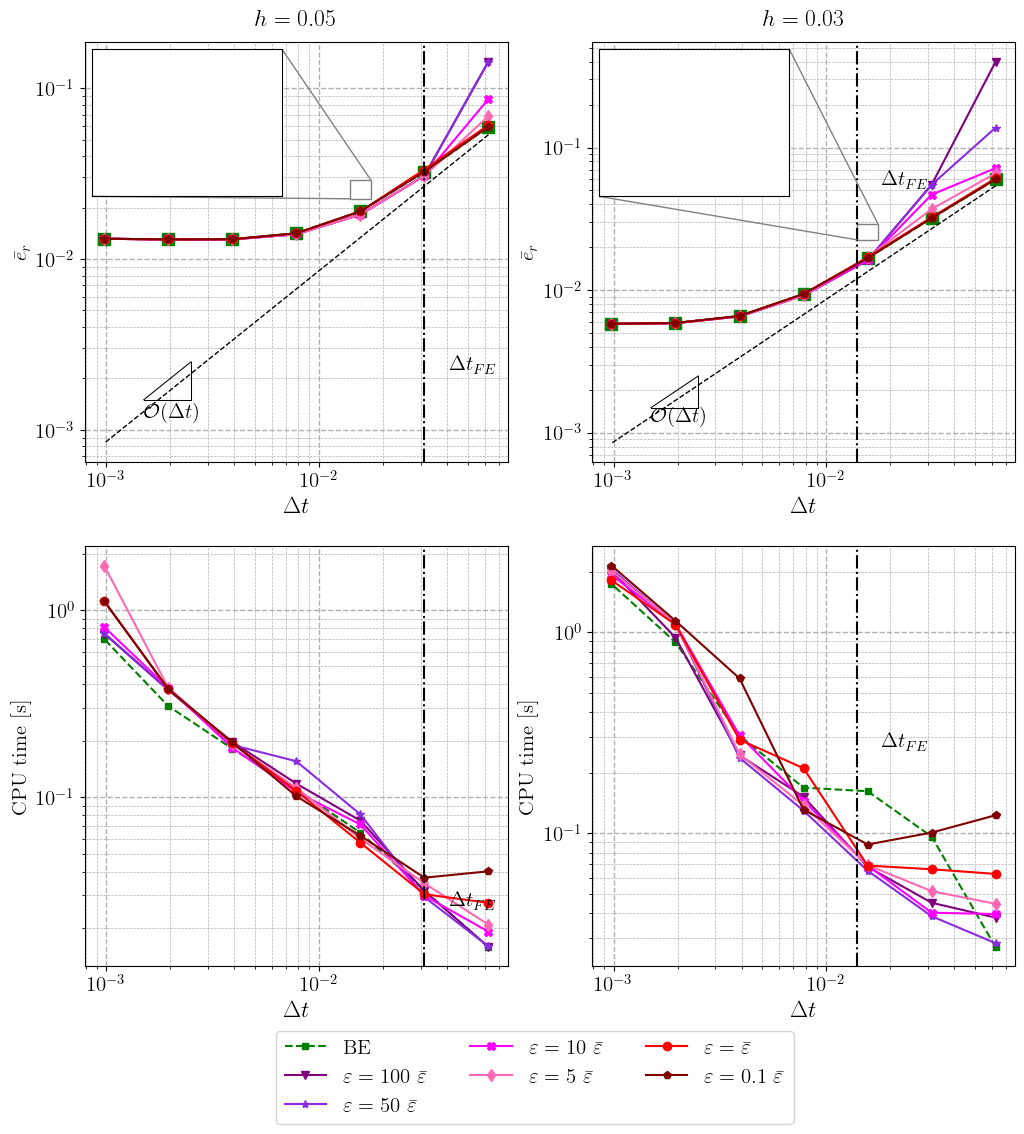

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plotting styles
all_markers = ['v', '*', 'X', 'd', 'o', 'p', 's', 'h']
all_colors = ['purple', 'blueviolet', 'magenta', 'hotpink',
              'red', 'maroon', 'teal', 'orange']
all_labels = [
    r"$\varepsilon = 100 \ \bar{\varepsilon}$",
    r"$\varepsilon = 50 \ \bar{\varepsilon}$",
    r"$\varepsilon = 10 \ \bar{\varepsilon}$",
    r"$\varepsilon = 5 \ \bar{\varepsilon}$",
    r"$\varepsilon = \bar{\varepsilon}$",
    r"$\varepsilon = 0.1 \ \bar{\varepsilon}$",
    r"$\varepsilon = 0.01 \ \bar{\varepsilon}$",
    r"$\varepsilon = 0.001 \ \bar{\varepsilon}$"
]


problem_name = 'AdvDiff2D'
# Load the single results file which now contains data for all Nx_values
results_path = os.path.join(
    base_dir,
    os.pardir,
    os.pardir,
    '__RESULTS',
    problem_name,
    testname,
    'results.npz'
)
results = np.load(results_path, allow_pickle=True)
Nx_values = results['Nx_values']         # array of grid sizes, length 2
Nts = results['Nt_values']               # timestep values
errBE_all = results['errors_l2'].item()['BE']         # shape: (len(Nts), len(Nx_values))
errIMEX_all = results['errors_l2'].item()['IMEX-RB']  # shape: (len(Nts), nIMEX, len(Nx_values))
timesBE_all = results['times'].item()['BE']           # shape: (len(Nts), len(Nx_values))
timesIMEX_all = results['times'].item()['IMEX-RB']    # shape: (len(Nts), nIMEX, len(Nx_values))
subiters_all = results['subiters'].item()['IMEX-RB']  # shape: (len(Nts), nIMEX, max_Nt, len(Nx_values))
Nt_FE_all = results['Nt_FE']           # array of FE stability thresholds, length len(Nx_values)

nIMEX = errIMEX_all.shape[1]  # number of epsilon cases

xdeltaFE = [1/Nt_FE*1.3 for Nt_FE in Nt_FE_all]
ydeltaFE = [1.2e-2, 0.1]

# Plot
for col, Nx in enumerate(Nx_values):
    # Grid-label on top of each column
    pos = axs[0, col].get_position()
    x = pos.x0 + pos.width / 2
    y = pos.y1 + 0.01
    fig.text(
        x, y,
        rf"$h = {1/Nx:.2f}$",
        ha="center", va="bottom", fontsize=17
    )

    # Extract data for this grid size
    errBE = errBE_all[:, col]
    errIMEX = errIMEX_all[:, :, col]
    timesBE = timesBE_all[:, col]
    timesIMEX = timesIMEX_all[:, :, col]
    Nt_FE = Nt_FE_all[col]

    # Top subplot: relative error with inset
    ax_err = axs[0, col]
    ax_err.loglog(1 / Nts, errBE, 's', linestyle='--',
                  markersize=8, color='green', label='BE')
    for idx in range(nIMEX):
        m = all_markers[idx]
        c = all_colors[idx]
        lbl = all_labels[idx]
        ax_err.loglog(1 / Nts, errIMEX[:, idx],
                      f'-{m}', markersize=6, color=c, label=lbl)
    # Reference O(Δt) line
    ax_err.loglog(1 / Nts,  (Nts[0] * errBE[0] * 0.9)  / Nts,
                  color='k', linestyle='--', linewidth=1)
    # Reference slope triangle
    x0, y0 = 0.0015, 0.0015
    dx = 0.001
    dy = dx
    ax_err.plot([x0, x0 + dx], [y0, y0], 'k-', linewidth=0.75)
    ax_err.plot([x0 + dx, x0 + dx], [y0, y0 + dy], 'k-', linewidth=0.75)
    ax_err.plot([x0 + dx, x0], [y0 + dy, y0], 'k-', linewidth=0.75)
    ax_err.text(x0, y0 - dy / 2.5, r"$\mathcal{O}(\Delta t)$",
                fontsize=15, ha='left', va='bottom')
    # FE stability vertical line
    ax_err.axvline(1 / Nt_FE, color='k', linestyle='-.')
    ax_err.text(
        xdeltaFE[col],
        ax_err.get_ylim()[1] * ydeltaFE[col],
        r"$\Delta t_{FE}$",
        fontsize=15,
        color='k'
    )

    axins = inset_axes(ax_err, width="45%", height="35%", loc='upper left')
    axins.loglog(1 / Nts, errBE, 's', markersize=8,
                 linestyle="--", color='green')
    for idx in range(nIMEX):
        m = all_markers[idx]
        c = all_colors[idx]
        axins.loglog(1 / Nts, errIMEX[:, idx],
                     f'-{m}', markersize=6, color=c)
    axins.set_xlim(1.4e-2, 1.75e-2)
    axins.set_ylim(2.25e-2, 2.9e-2)
    axins.tick_params(axis='both', which='both',
                      bottom=False, top=False,
                      left=False, right=False,
                      labelbottom=False, labelleft=False)
    mark_inset(ax_err, axins, loc1=1, loc2=3, fc="none", ec="0.5")

    ax_err.grid(which='major', linewidth=1, linestyle='--')
    ax_err.grid(which='minor', linewidth=0.5, linestyle='--')
    ax_err.tick_params(axis='both', which='major', labelsize=15)
    ax_err.set_xlabel(r"$\Delta t$", fontsize=17)
    ax_err.set_ylabel(r"$\bar{e}_r$", fontsize=15)

    # Bottom subplot: CPU time
    ax_time = axs[1, col]
    ax_time.loglog(1 / Nts, timesBE, '--s', markersize=4,
                   color='green', label='BE')
    for idx in range(nIMEX):
        m = all_markers[idx]
        c = all_colors[idx]
        lbl = all_labels[idx]
        ax_time.loglog(1 / Nts, timesIMEX[:, idx],
                       f'-{m}', markersize=6, color=c, label=lbl)

    ax_time.axvline(1 / Nt_FE, color='k', linestyle='-.')
    ax_time.text(
        xdeltaFE[col],
        ax_time.get_ylim()[1] * ydeltaFE[col],
        r"$\Delta t_{FE}$",
        fontsize=15,
        color='k'
    )
    ax_time.tick_params(axis='both', which='major', labelsize=15)
    ax_time.grid(which='major', linestyle='--', linewidth=1)
    ax_time.grid(which='minor', linestyle='--', linewidth=0.5)
    ax_time.set_xlabel(r"$\Delta t$", fontsize=17)
    ax_time.set_ylabel("CPU time [s]", fontsize=15)

# External legend for both error and time plots
handles, labels = axs[1, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.03),
    fontsize=15,
    ncol=3
)

plt.savefig('plots/' + f'{problem_name}_' + f'convergence_times_eps.pdf', bbox_inches="tight")


### Process subiterations for a given space discretization
Look at average inner iterations varying $\Delta t$ and iterations over time
for one $\Delta t$

In [4]:
# Read now a single result file, i.e. a single Nx
idx_Nx = 1
# Extract data for this grid size
errBE = errBE_all[:, col]
errIMEX = errIMEX_all[:, :, col]
timesBE = timesBE_all[:, col]
timesIMEX = timesIMEX_all[:, :, col]
Nt_FE = Nt_FE_all[col]
subiters = subiters_all[:, :, :, col]
# Masking sub-iterations
mask = np.zeros_like(subiters, dtype=bool)
for i, _Nt in enumerate(Nts):
    mask[i, :, :_Nt] = True
masked_subiters = np.ma.masked_array(subiters, mask=~mask)

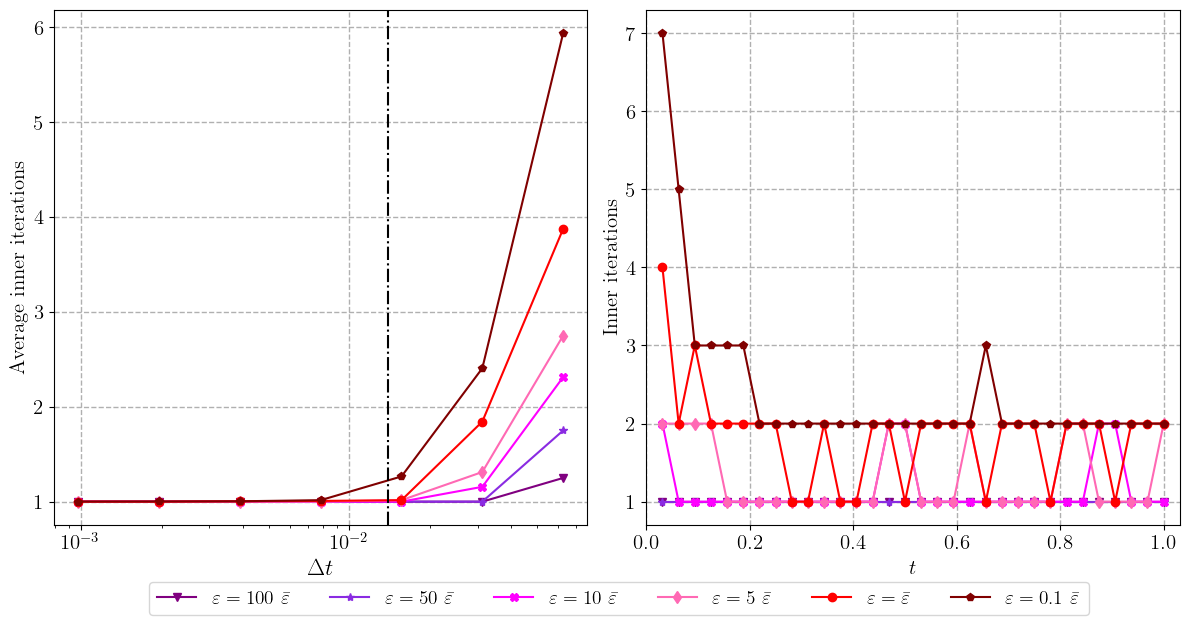

In [5]:
# Range for epsilon cases are available
indices = list(range(nIMEX))

markers = all_markers[:nIMEX]
colors = all_colors[:nIMEX]
labels = all_labels[:nIMEX]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Left subplot: average inner iterations vs Δt
ax = axs[0]
for idx, m, c, lbl in zip(indices, markers, colors, labels):
    mean_iter = np.mean(masked_subiters[:, idx] + 1, axis=-1)
    ax.semilogx(
        1 / Nts,
        mean_iter,
        f'-{m}',
        markersize=6,
        color=c,
        label=lbl
    )
ax.axvline(1 / Nt_FE, color='k', linestyle='-.')
# ax.text(5.7e-3, 16.3, r"$\Delta t_{FE}$", fontsize=15, color='k')
ax.grid(which='major', linestyle='--', linewidth=1)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel(r"$\Delta t$", fontsize=17)
ax.set_ylabel("Average inner iterations", fontsize=15)

# Right subplot: inner iterations vs time for Nt_idx = 1
ax = axs[1]
Nt_idx = 1
tvec = np.linspace(0, 1, Nts[Nt_idx] + 1)[1:]
for idx, m, c, lbl in zip(indices, markers, colors, labels):
    ax.plot(
        tvec,
        subiters[Nt_idx, idx, :Nts[Nt_idx]] + 1,
        f'-{m}',
        markersize=6,
        color=c,
        label=lbl
    )
ax.grid(which='major', linestyle='--', linewidth=1)
ax.set_xlim([0, 1 + 1 / Nts[Nt_idx]])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r"$t$", fontsize=15)
ax.set_ylabel("Inner iterations", fontsize=15)

# Single external legend on the right, one column
handles, legend_labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    legend_labels,
    loc='lower center',
    bbox_to_anchor=(0.52, -0.05),
    fontsize=14,
    ncol=7
)

plt.tight_layout()
plt.savefig('plots/' + f'{problem_name}_' + f'iters_eps_Nx_{Nx_values[idx_Nx]}.pdf', bbox_inches="tight")